In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, PowerTransformer

import statsmodels.api as sm


In [2]:
train = pd.read_csv('./datasets/train.csv')
test = pd.read_csv('./datasets/test.csv')

# Cleaning Train data:

In [3]:
train.shape

(2051, 81)

In [38]:
train.head(1)

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,4,3,CBlock,3.0,3.0,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,5,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,4,6,Typ,0,NaN,Attchd,1976.0,RFn,2.0,475.0,3.0,3.0,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,130500


In [5]:
pd.set_option('max_columns', 99) # change set columns and rows for viewing of data
pd.set_option('max_rows', 99)

In [6]:
# making the column heads look conventional

train.columns = train.columns.str.lower().str.replace(" ", "_")

In [7]:
train.dtypes;

In [8]:
### replacing nulls in certain columns with that column's mean:

null_cols = ['mas_vnr_area', 'total_bsmt_sf', 'garage_yr_blt', 'garage_cars', 'garage_area']

def repl_nulls_w_mean(columns):
    for item in columns:
        item_mean = train[item].mean()
        train[item].fillna(value = item_mean, inplace=True)
        
repl_nulls_w_mean(null_cols)

Text(0.5, 1.0, 'garage_yr_blt vs. saleprice')

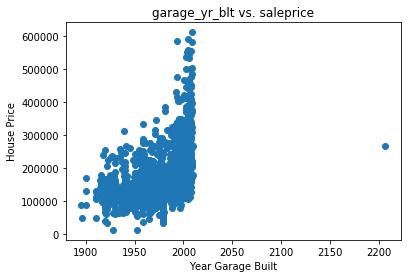

In [9]:
plt.scatter(train['garage_yr_blt'], train['saleprice'])
plt.xlabel("Year Garage Built")
plt.ylabel("House Price")
plt.title('garage_yr_blt vs. saleprice')

In [10]:
# came back up here to drop the following, after looking at some specific scatterplots

# dropping a row with an error in the garage_yr_blt column and says 2207
train.drop(train.loc[train['garage_yr_blt'] > 2020].index, inplace=True)

# dropping a couple outliers in the total_bsmt_sf column
train.drop(train.loc[train['total_bsmt_sf'] > 5000].index, inplace=True)

# dropping an outlier in the 1st_flr_sf column
train.drop(train.loc[train['1st_flr_sf'] > 3500].index, inplace=True)

# dropping a few outliers in the year_built column
train.drop(train.loc[train['year_built'] == 1892].index, inplace=True)
train.drop([1939, 1141], axis=0, inplace=True)
train.drop([1897], axis=0, inplace=True)

In [11]:
# how I targeted a row within a dataset. There's probably an easier way to do it.

# asdf = train.loc[train['year_built'] < 1940];
# asdf.loc[train['saleprice'] > 400000];

In [12]:
train.isnull().sum().sort_values();

In [13]:
## Replacing categorical columns with numbers to check for correlations against price
# from Dylan 

category_key = {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}

train = train.replace(category_key)

# Cleaning Test data

In [14]:
test.shape

(878, 80)

In [15]:
features = ['overall_qual', 'year_built', 'year_remod/add', 'mas_vnr_area',
            'total_bsmt_sf', '1st_flr_sf', 'gr_liv_area', 'full_bath',
            'garage_yr_blt', 'garage_cars', 'garage_area', 'exter_qual', 'kitchen_qual']

def clean_data(df):
    df.columns = df.columns.str.lower().str.replace(" ", "_")
    print("Before replacing nulls with means:", df[features].isnull().sum())
    def repl_nulls_w_mean(columns):
        for item in columns:
            item_mean = df[item].mean()
            df[item].fillna(value = item_mean, inplace=True)
    repl_nulls_w_mean(null_cols) # nulls_cols was defined earlier in the notebook
    print("After replacing nulls with means:", df[features].isnull().sum())

test = test.replace(category_key) # for some reason this wouldn't run in the function

clean_data(test)

Before replacing nulls with means: overall_qual       0
year_built         0
year_remod/add     0
mas_vnr_area       1
total_bsmt_sf      0
1st_flr_sf         0
gr_liv_area        0
full_bath          0
garage_yr_blt     45
garage_cars        0
garage_area        0
exter_qual         0
kitchen_qual       0
dtype: int64
After replacing nulls with means: overall_qual      0
year_built        0
year_remod/add    0
mas_vnr_area      0
total_bsmt_sf     0
1st_flr_sf        0
gr_liv_area       0
full_bath         0
garage_yr_blt     0
garage_cars       0
garage_area       0
exter_qual        0
kitchen_qual      0
dtype: int64


In [16]:
test.head()

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2Story,6,8,1910,1950,Gable,CompShg,AsbShng,AsbShng,None,0.0,3,2,Stone,2.0,3.0,No,Unf,0,Unf,0,1020,1020,GasA,4,N,FuseP,908,1020,0,1928,0,0,2,0,4,2,2,9,Typ,0,NaN,Detchd,1910.0,Unf,1,440,1.0,1.0,Y,0,60,112,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,Duplex,1Story,5,4,1977,1977,Gable,CompShg,Plywood,Plywood,None,0.0,3,3,CBlock,4.0,3.0,No,Unf,0,Unf,0,1967,1967,GasA,3,Y,SBrkr,1967,0,0,1967,0,0,2,0,6,2,3,10,Typ,0,NaN,Attchd,1977.0,Fin,2,580,3.0,3.0,Y,170,0,0,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,7,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,None,0.0,4,3,PConc,4.0,4.0,Av,GLQ,554,Unf,0,100,654,GasA,5,Y,SBrkr,664,832,0,1496,1,0,2,1,3,1,4,7,Typ,1,4.0,Attchd,2006.0,RFn,2,426,3.0,3.0,Y,100,24,0,0,0,0,NaN,NaN,NaN,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,5,6,1923,2006,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,4,3,CBlock,3.0,3.0,No,Unf,0,Unf,0,968,968,GasA,3,Y,SBrkr,968,0,0,968,0,0,1,0,2,1,3,5,Typ,0,NaN,Detchd,1935.0,Unf,2,480,2.0,3.0,N,0,0,184,0,0,0,NaN,NaN,NaN,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1963,1963,Gable,CompShg,Plywood,Plywood,BrkFace,247.0,3,3,CBlock,4.0,3.0,No,BLQ,609,Unf,0,785,1394,GasA,4,Y,SBrkr,1394,0,0,1394,1,0,1,1,3,1,3,6,Typ,2,4.0,Attchd,1963.0,RFn,2,514,3.0,3.0,Y,0,76,0,0,185,0,NaN,NaN,NaN,0,7,2009,WD


# EDA

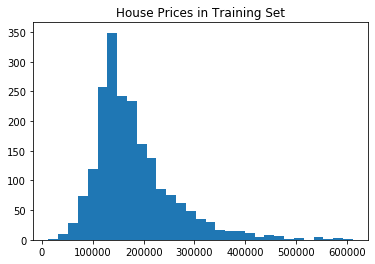

In [17]:
plt.hist(train['saleprice'], bins=31);
plt.title('House Prices in Training Set');

# very skewed means we're going to use a log transformation later to normalize it

In [18]:
train.corrwith(train['saleprice']).sort_values();

X-variables with > ~50% correlation to use in model:

overall_qual, year_built, year_remod/add, mas_vnr_area, total_bsmt_sf, 1st_flr_sf, gr_liv_area, full_bath, garage_yr_blt, garage_cars, garage_area

In [19]:
# assigning a variable to all of the df's series that I'm going to use as x-variables

features = ['overall_qual', 'year_built', 'year_remod/add', 'mas_vnr_area',
            'total_bsmt_sf', '1st_flr_sf', 'gr_liv_area', 'full_bath',
            'garage_yr_blt', 'garage_cars', 'garage_area', 'exter_qual', 'kitchen_qual']
train[features];
train[features].isnull().sum()

overall_qual      0
year_built        0
year_remod/add    0
mas_vnr_area      0
total_bsmt_sf     0
1st_flr_sf        0
gr_liv_area       0
full_bath         0
garage_yr_blt     0
garage_cars       0
garage_area       0
exter_qual        0
kitchen_qual      0
dtype: int64

In [20]:
correlations = train[features].corrwith(train['saleprice']).sort_values(ascending=False)
correlations

overall_qual      0.805062
exter_qual        0.719481
gr_liv_area       0.717267
kitchen_qual      0.693431
total_bsmt_sf     0.668527
garage_area       0.653442
1st_flr_sf        0.651122
garage_cars       0.649332
year_built        0.591220
year_remod/add    0.552065
full_bath         0.534586
garage_yr_blt     0.525170
mas_vnr_area      0.523672
dtype: float64

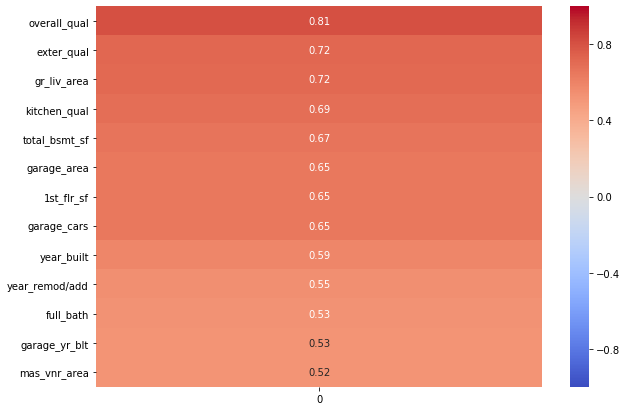

In [21]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(correlations.to_frame(), 
            cmap='coolwarm',
            annot=True,
            vmin=-1,
            vmax=1,
            ax=ax)

Text(0.5, 1.0, 'garage_yr_blt vs. saleprice')

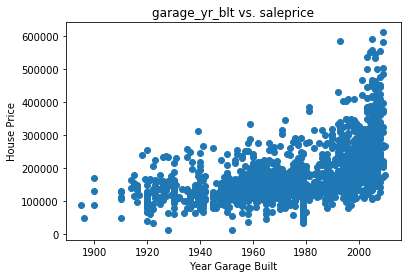

In [22]:
plt.scatter(train['garage_yr_blt'], train['saleprice'])
plt.xlabel("Year Garage Built")
plt.ylabel("House Price")
plt.title('garage_yr_blt vs. saleprice')

# 2. Modeling

In [23]:
X = train[features]
y = train['saleprice']

In [24]:
# Run a train_test_split:

X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, random_state = 42)

# instantiate a model
lr = LinearRegression()

# fit the model
lr.fit(X_train, y_train)
predictions = lr.predict(X_holdout)

# Cross Validating

cv_scores = cross_val_score(lr, X, y, cv=5)
print("Cross validation scores:", cv_scores)
print("Cross-Val mean of scores:", cv_scores.mean())

Cross validation scores: [0.82062423 0.87299807 0.85644648 0.85315704 0.84844726]
Cross-Val mean of scores: 0.8503346175889073


Score: 0.8424087168933342


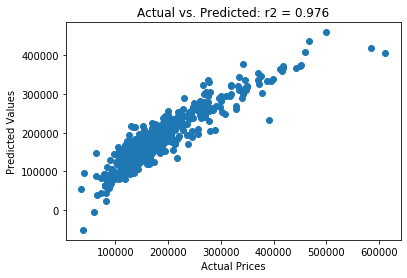

In [25]:
plt.scatter(y_holdout, predictions)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Values")
plt.title('Actual vs. Predicted: r2 = 0.976')

print("Score:", lr.score(X_holdout, y_holdout)) #

In [26]:
# function to find RMSE

def get_rmse(preds, y_holdout_vals):
    rmse = np.sqrt(np.mean((y_holdout_vals - preds)**2)) # RMSE
    print('RMSE:', rmse)
          
get_rmse(predictions, y_holdout)

RMSE: 31451.854593981632


In [27]:
model = sm.OLS(y, X)
model_results = model.fit()
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              saleprice   R-squared (uncentered):                   0.976
Model:                            OLS   Adj. R-squared (uncentered):              0.976
Method:                 Least Squares   F-statistic:                              6290.
Date:                Fri, 17 Jan 2020   Prob (F-statistic):                        0.00
Time:                        13:31:26   Log-Likelihood:                         -24009.
No. Observations:                2043   AIC:                                  4.804e+04
Df Residuals:                    2030   BIC:                                  4.812e+04
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
overall_qual    1.291e+04    870.437     14.828      0.000    1.12e+04    1.46e+04
year_built       168.7340     42.413      3.978      0.000      85.557     251.911
year_remod/add   -61.5269     38.954     -1.579      0.114    -137.921      14.868
mas_vnr_area      42.5747      4.628      9.200      0.000      33.499      51.650
total_bsmt_sf     28.1405      2.945      9.556      0.000      22.365      33.916
1st_flr_sf        13.4075      3.356      3.995      0.000       6.826      19.989
gr_liv_area       49.5115      2.198     22.526      0.000      45.201      53.822
full_bath      -5426.0468   1726.427     -3.143      0.002   -8811.800   -2040.294
garage_yr_blt   -184.8797     48.618     -3.803      0.000    -280.227     -89.533
garage_cars      568.1296   2172.559      0.262      0.794   -3692.549    4828.808
garage_area       42.2536      7.625      5.542      0.000      27.301      57.207
exter_qual      1.972e+04   1991.271      9.901      0.000    1.58e+04    2.36e+04
kitchen_qual    1.557e+04   1630.830      9.550      0.000    1.24e+04    1.88e+04
==============================================================================
Omnibus:                      373.073   Durbin-Watson:                   2.095
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2791.670
Skew:                           0.649   Prob(JB):                         0.00
Kurtosis:                       8.578   Cond. No.                     1.34e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
### For Kaggle

X_test = test[features]

X_test.shape

X_test_preds = lr.predict(X_test)
X_test_preds.shape

test['saleprice'] = X_test_preds

submission = test[['id', 'saleprice']]

# submission.to_csv('./submissions01_16_draft.csv', index = False)

# Transform, Standardize, Regularize, and Remodel

In [29]:
# Up in EDA we saw that the sales prices were very right skewed, so let's normalize it:

y_train_transformed = np.log1p(y_train)

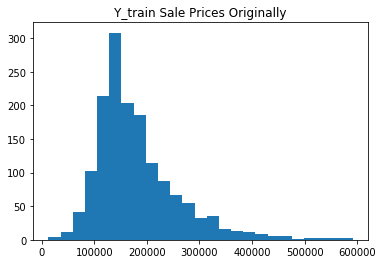

In [30]:
plt.hist(y_train, bins=25);
plt.title('Y_train Sale Prices Originally');

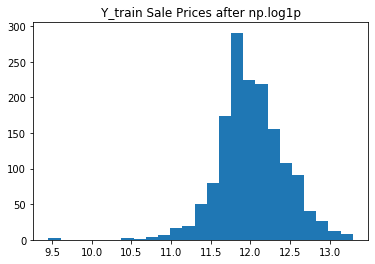

In [31]:
plt.hist(y_train_transformed, bins=25);
plt.title('Y_train Sale Prices after np.log1p');

In [32]:
# Now let's standardize the X_train data.

ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_holdout_sc = ss.fit_transform(X_holdout)

In [33]:
# Now we regularize with Ridge

ridge = Ridge()
ridge.fit(X_train_sc, y_train_transformed)
ridge_preds = ridge.predict(X_holdout_sc)

In [34]:
ridge_score = cross_val_score(ridge, X_train_sc, y_train_transformed, cv = 5)
print('Ridge Score:', ridge_score)
print('Ridge Score mean:', ridge_score.mean())

Ridge Score: [0.85462047 0.83019001 0.83238981 0.88031873 0.87098479]
Ridge Score mean: 0.8537007627992989


In [35]:
ridge_preds_norm = np.expm1(ridge_preds)

In [36]:
get_rmse(ridge_preds_norm, y_holdout)

RMSE: 27118.678515168496


In [37]:
# running predictions on Test data and creating .csv for Kaggle submission
X_test_sc = ss.fit_transform(X_test)
X_test_sc_preds = ridge.predict(X_test_sc)
X_test_preds_norm = np.expm1(X_test_sc_preds)

test['saleprice'] = X_test_preds_norm
submission = test[['id', 'saleprice']]
submission.to_csv('./submissions01_17_final.csv', index = False)

# Recommendations: Some of the more intuitive reasons for the houses' values, like the square footage or the year it was built, can't be changed. However, what can modify are attributes like the external quality and the overall quality of the house. Renovating an older home would up those categories too.